In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\install\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [38]:
df_train = pd.read_csv('train.csv')

In [5]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1.Exploratory data analysis 

### Analysing 'SalePrice'

In [6]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

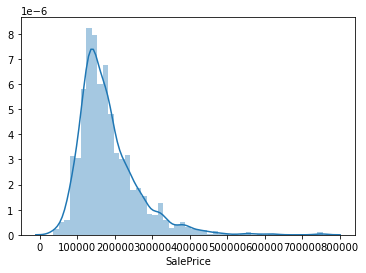

In [7]:
#histogram
sns.distplot(df_train['SalePrice']);

### Relationship with numerical variables

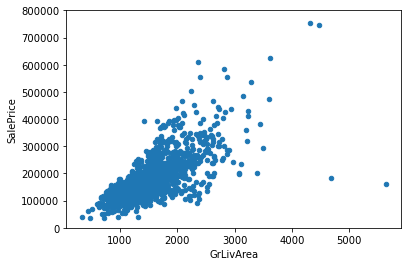

In [8]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

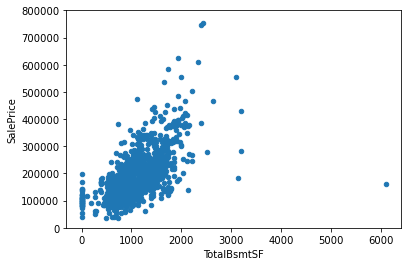

In [8]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

### Relationship with categorical features

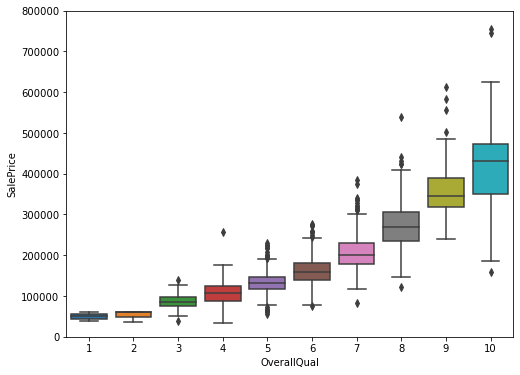

In [9]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

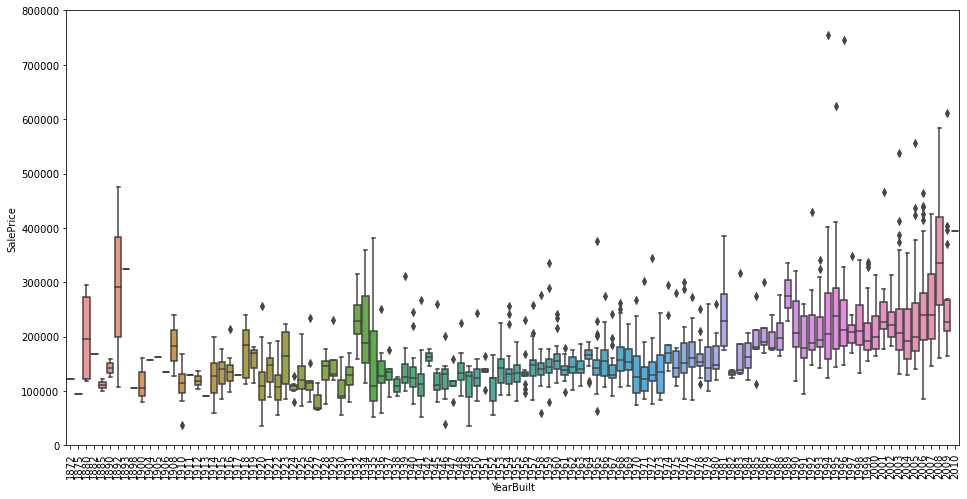

In [11]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In summary
Stories aside, we can conclude that:

- 'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
- 'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of - 'OverallQual', where the box plot shows how sales prices increase with the overall quality.

### 'SalePrice' correlation matrix (zoomed heatmap style)

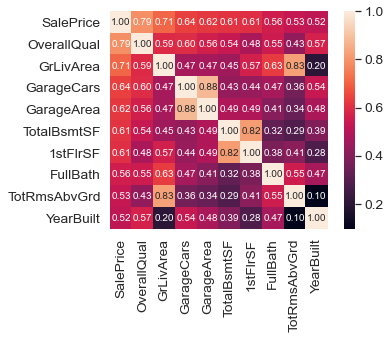

In [10]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Scatter plots between 'SalePrice' and correlated variables

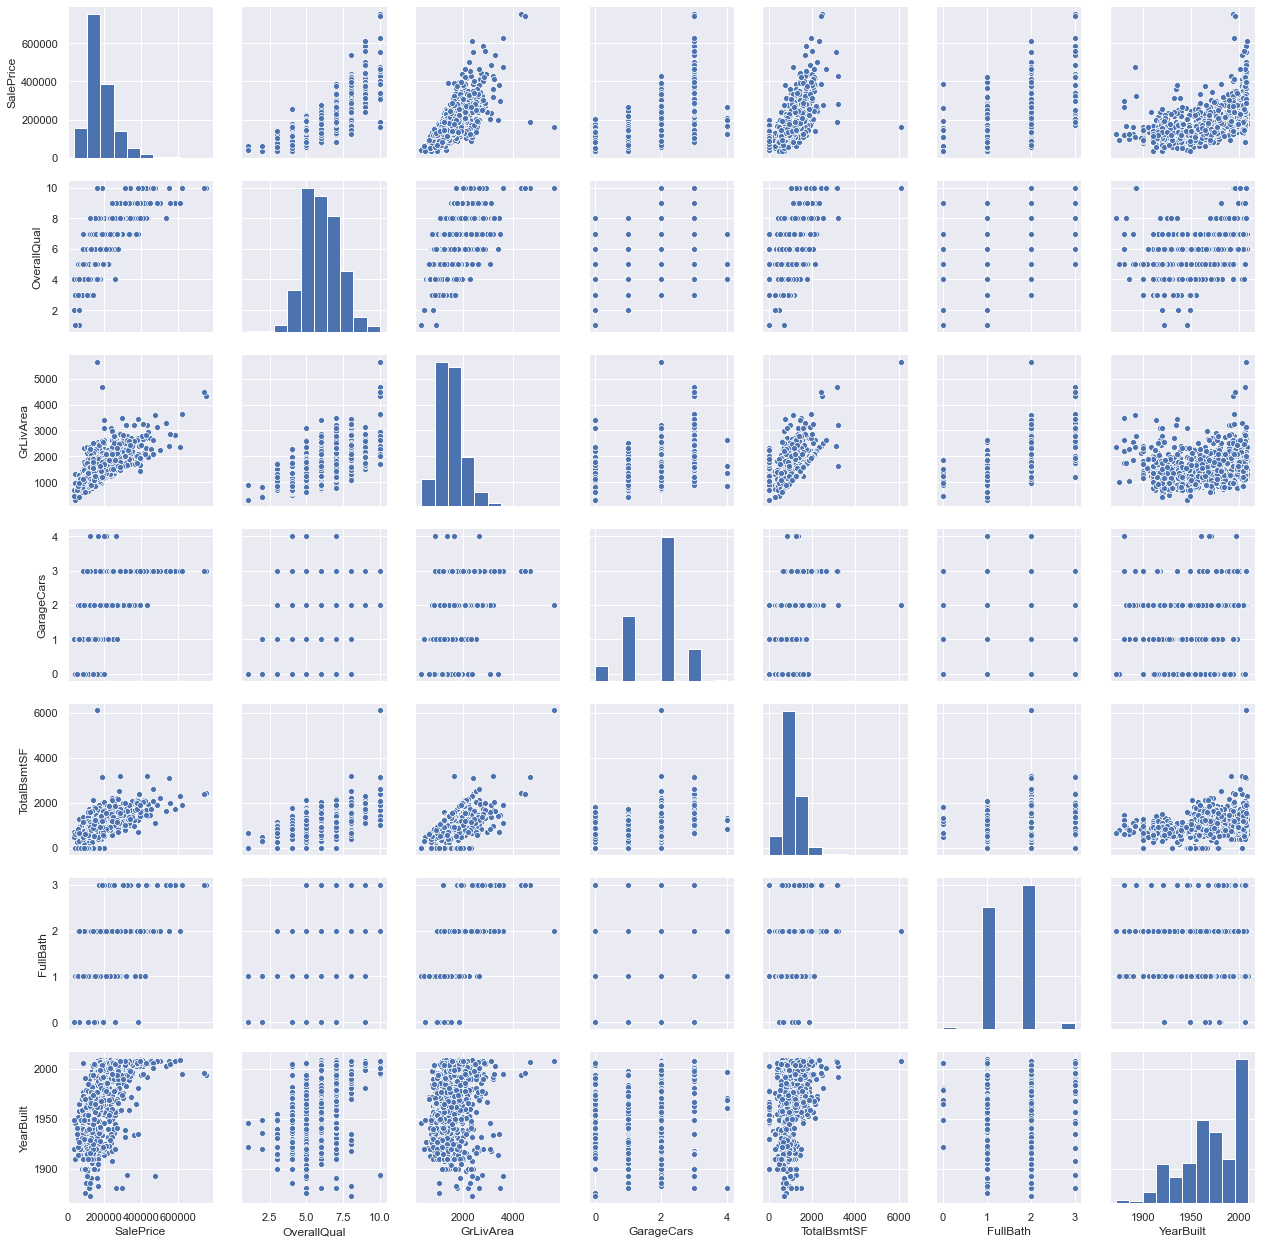

In [11]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

### Conclusion
- 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. 
- 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
- 'TotalBsmtSF' and '1stFloor' also seem to be twin brothers.  We can keep 'TotalBsmtSF'

## 2. Missing Data

In [39]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [40]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [14]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [15]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

## 4. Baseline Model

### Decision Tree

In [41]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary

In [42]:
predictors=['SalePrice','OverallQual','GrLivArea','TotalBsmtSF','GarageCars','OverallQual', 'FullBath', 'YearBuilt']

In [43]:
df_train=df_train[predictors]

In [44]:
X = df_train.drop(columns=['SalePrice'])
y = df_train['SalePrice']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)

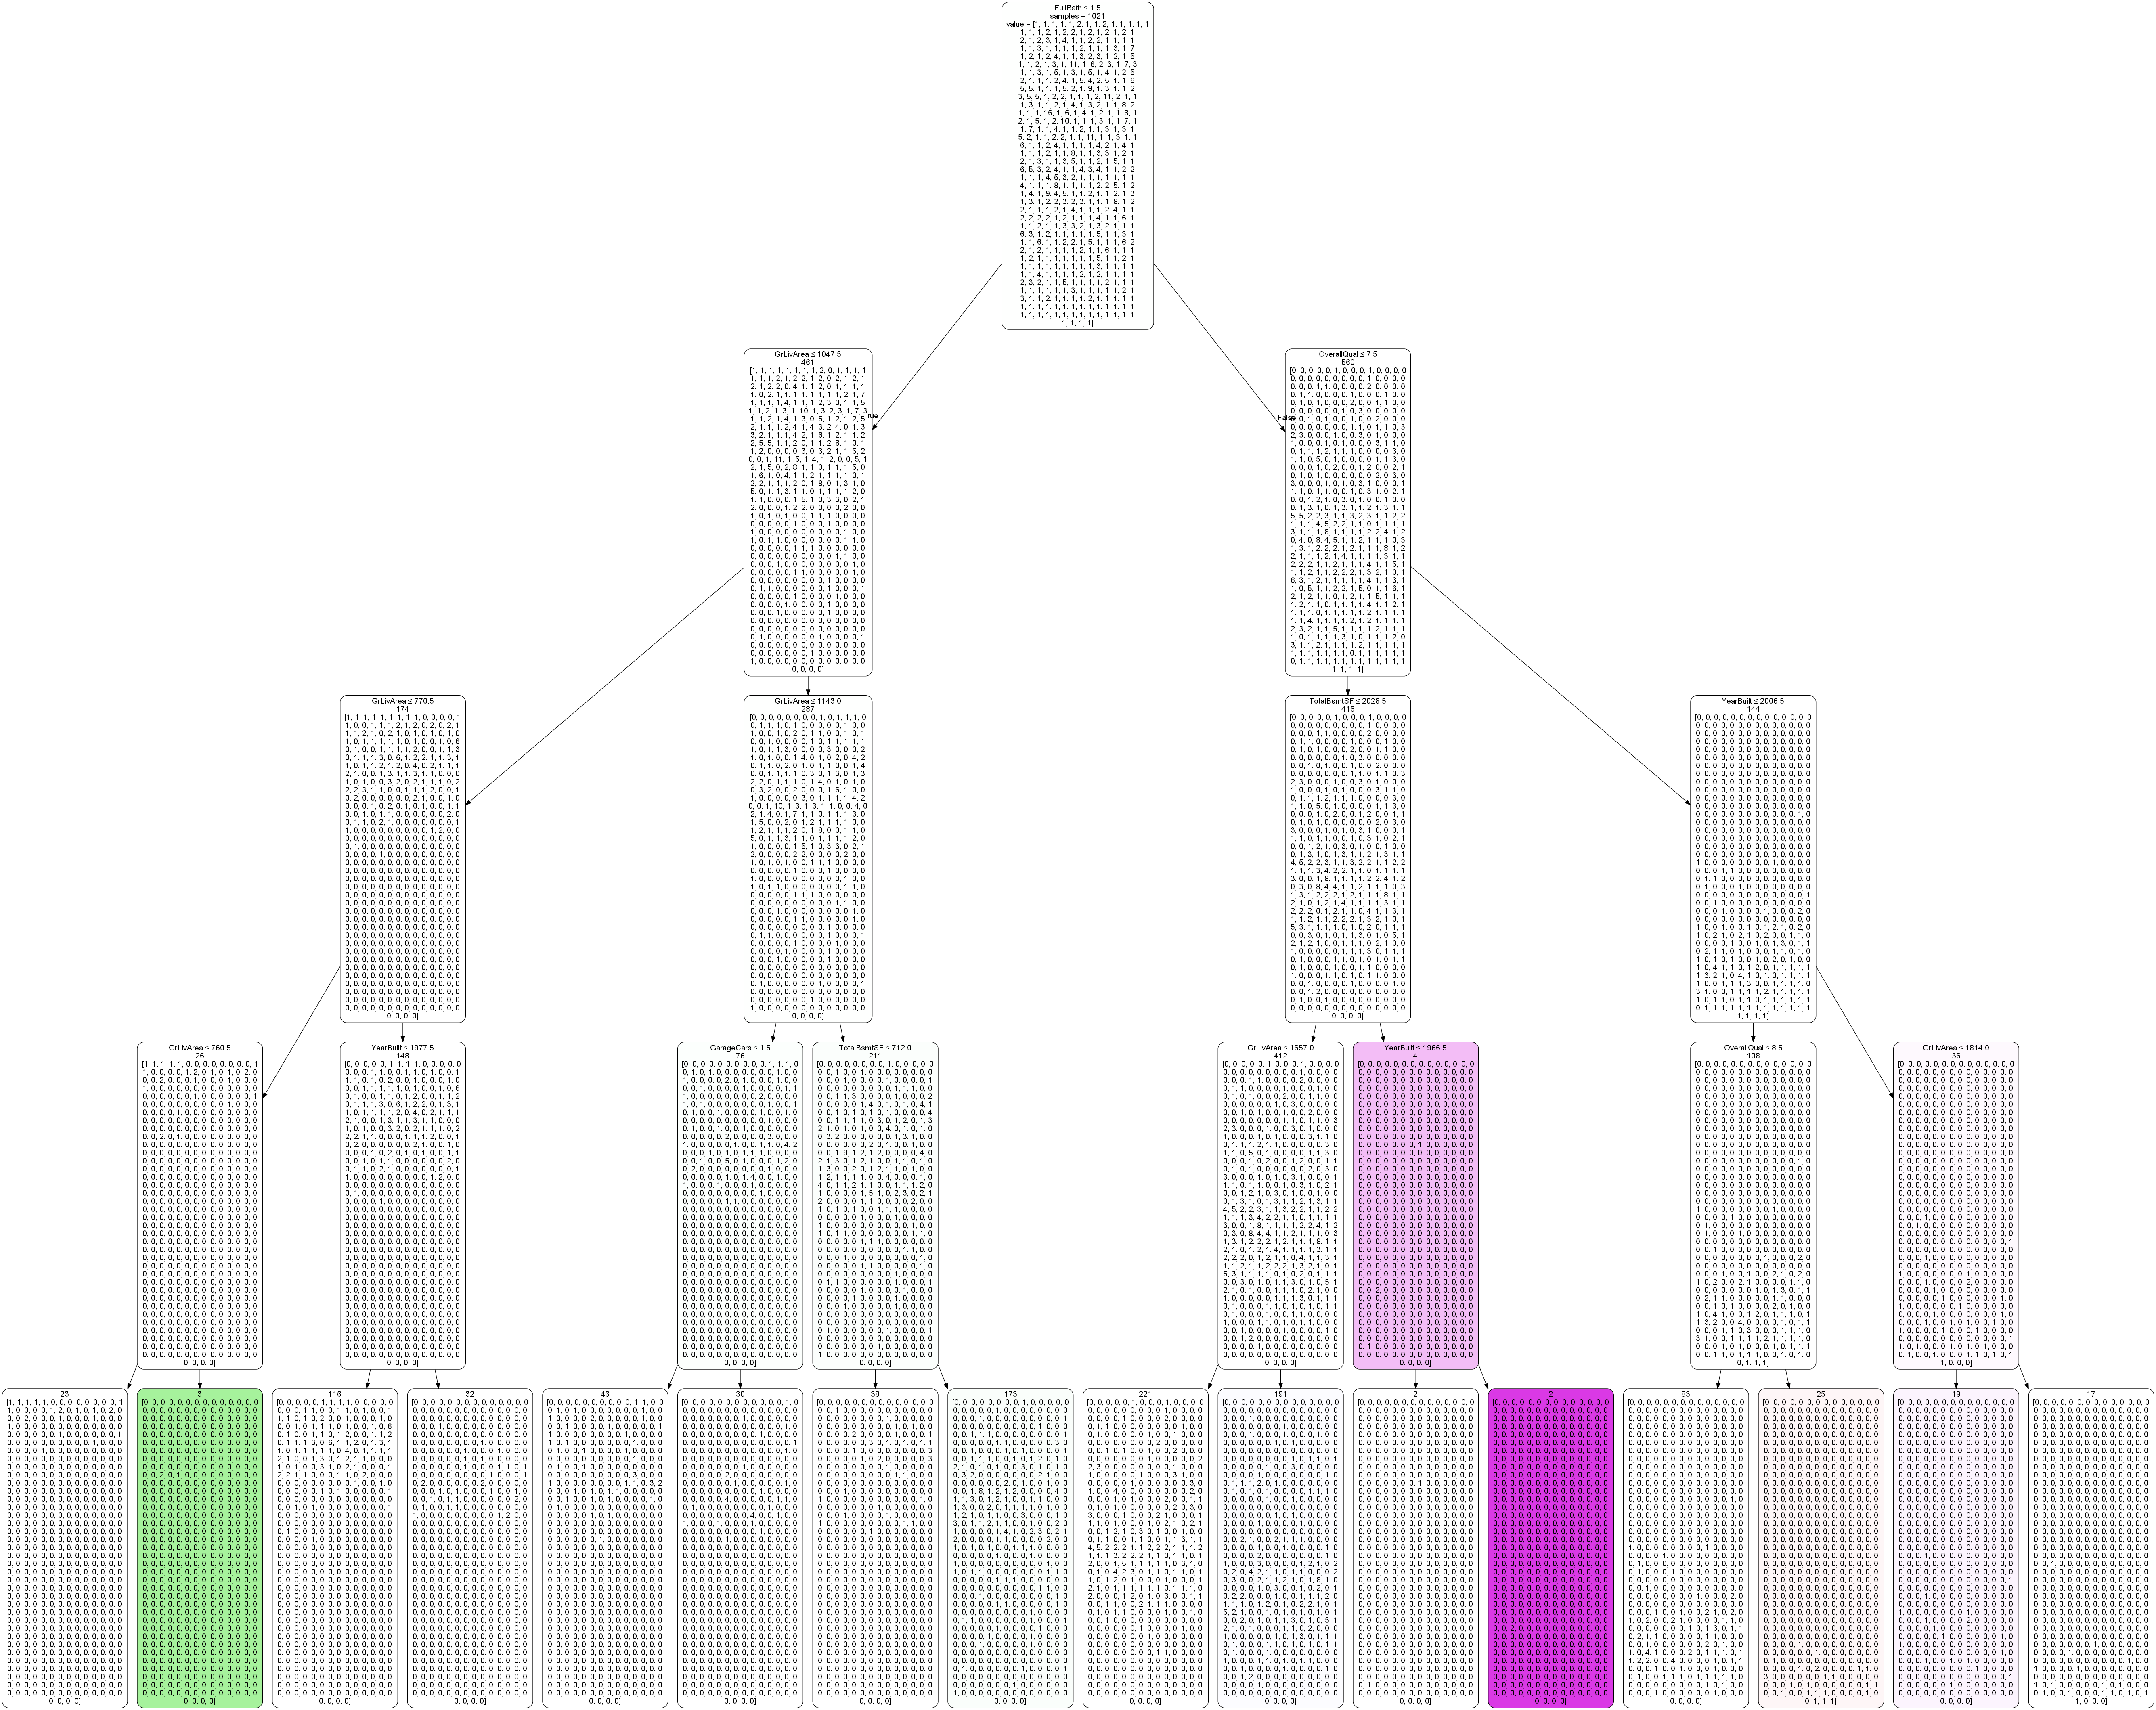

In [21]:
#Build decision tree

#code here
DecisionTree = DecisionTreeClassifier(max_depth=4)
DecisionTree.fit(train_X, train_y)

plotDecisionTree(DecisionTree, feature_names=train_X.columns)

In [22]:
#get the accuracy score
from sklearn.metrics import accuracy_score
# Get the prediction for both train and test
prediction_train = DecisionTree.predict(train_X)#use the DT model to predict on the training data
prediction_valid =  DecisionTree.predict(valid_X)#use the DT model to predict on the validation data

# Measure the accuracy of the model for both train and test sets
print("Accuracy on train is:",accuracy_score(train_y,prediction_train))
print("Accuracy on test is:",accuracy_score(valid_y,prediction_valid))

Accuracy on train is: 0.05484818805093046
Accuracy on test is: 0.00684931506849315


### Random Forest

       feature  importance       std
5     FullBath    0.026873  0.011585
0  OverallQual    0.038157  0.013722
4  OverallQual    0.038516  0.013847
3   GarageCars    0.053795  0.012663
6    YearBuilt    0.259930  0.019058
2  TotalBsmtSF    0.286248  0.019520
1    GrLivArea    0.296480  0.020919


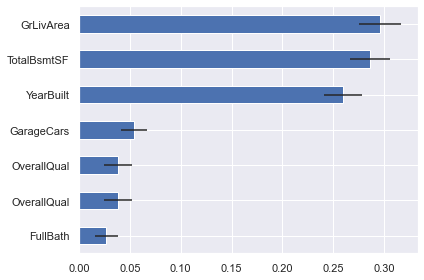

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

### Logistical Regression

In [24]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

#code here
# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns))
print()

intercept  1.6915747546742594
                coeff
OverallQual -0.817100
GrLivArea   -0.026150
TotalBsmtSF  0.022541
GarageCars  -9.286256
OverallQual -0.817100
FullBath    -0.798293
YearBuilt    0.003142



In [25]:
prediction_train = logit_reg.predict(train_X)
prediction_valid = logit_reg.predict(valid_X)
print("Accuracy on train is:",accuracy_score(train_y,prediction_train))
print("Accuracy on test is:",accuracy_score(valid_y,prediction_valid))

Accuracy on train is: 0.14103819784524976
Accuracy on test is: 0.0045662100456621


# Naive Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import MultinomialNB
# run naive Bayes

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)
nb = GaussianNB()
nb.fit(train_X, train_y)

# predict probabilities
prediction_train = nb.predict_proba(train_X)
prediction_valid = nb.predict_proba(valid_X)
print(pd.DataFrame({'coeff': nb.theta_[0]}, index=X.columns))
print() 

              coeff
OverallQual     4.0
GrLivArea     720.0
TotalBsmtSF   720.0
GarageCars      0.0
OverallQual     4.0
FullBath        1.0
YearBuilt    1920.0



# XGBoost

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

from xgboost import XGBRegressor


In [55]:
X = df_train.drop(columns=['SalePrice'])
y = df_train['SalePrice']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)

In [56]:
my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [57]:

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [58]:
# make predictions
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 21726.935511201485
